This one is going through a harmonic oscillator. Gave us the first instance of returning back that the variables were very dependent upon each other.

## PyVBMC Toy Model

In this notebook we'll walk through how to solve a parameter estimation problem for a toy ODE problem. To get started, import all the packages we'll be needing:

In [52]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
import csv

In [53]:
def model(X, t, m, b, k):
    # m, b, k = 3, 1.5, 1
    x, vx =  X[0], X[1]
    dx = vx
    dv = (1/ m) * (-k * x - b * vx)
    return [dx, dv]

In [54]:
initial_condition = [1.0, 5.0]
# time points
t = np.linspace(0, 20, 100)
m, b, k = 3, 1.5, 1.
# solve ODE
# print(k)
solu = odeint(model, initial_condition, t, args=(m, b, k))
print(type(solu))
print(solu)


<class 'numpy.ndarray'>
[[ 1.00000000e+00  5.00000000e+00]
 [ 1.95201319e+00  4.42394577e+00]
 [ 2.78733108e+00  3.84605764e+00]
 [ 3.50636903e+00  3.27398092e+00]
 [ 4.11100519e+00  2.71455128e+00]
 [ 4.60441601e+00  2.17378422e+00]
 [ 4.99091032e+00  1.65687600e+00]
 [ 5.27576484e+00  1.16821538e+00]
 [ 5.46506300e+00  7.11404331e-01]
 [ 5.56553885e+00  2.89287089e-01]
 [ 5.58442743e+00 -9.60137771e-02]
 [ 5.52932321e+00 -4.43055478e-01]
 [ 5.40804732e+00 -7.51028311e-01]
 [ 5.22852478e+00 -1.01970536e+00]
 [ 4.99867200e+00 -1.24938940e+00]
 [ 4.72629534e+00 -1.44085809e+00]
 [ 4.41900076e+00 -1.59530829e+00]
 [ 4.08411478e+00 -1.71430035e+00]
 [ 3.72861663e+00 -1.79970299e+00]
 [ 3.35908143e+00 -1.85363952e+00]
 [ 2.98163399e+00 -1.87843596e+00]
 [ 2.60191297e+00 -1.87657150e+00]
 [ 2.22504464e+00 -1.85063170e+00]
 [ 1.85562592e+00 -1.80326490e+00]
 [ 1.49771576e+00 -1.73714193e+00]
 [ 1.15483442e+00 -1.65491944e+00]
 [ 8.29969685e-01 -1.55920694e+00]
 [ 5.25589427e-01 -1.45253755e+

In [55]:
# s = np.random.normal(0, .1, )
y = solu[:, 1]
# print(len(y))
changed = y + np.random.normal(0, .1, 100)
solu2 = np.ndarray((100,2))
for i in range(100):
    solu2[i, 0] = solu[i, 0]
    solu2[i, 1] = changed[i]
    if i == 0:
        solu2[i, 0] = solu[i, 0]
        solu2[i, 1] = 5.0

print(solu2)

[[ 1.00000000e+00  5.00000000e+00]
 [ 1.95201319e+00  4.47057938e+00]
 [ 2.78733108e+00  3.84638039e+00]
 [ 3.50636903e+00  3.20716999e+00]
 [ 4.11100519e+00  2.82625080e+00]
 [ 4.60441601e+00  2.10373517e+00]
 [ 4.99091032e+00  1.64330217e+00]
 [ 5.27576484e+00  1.22473312e+00]
 [ 5.46506300e+00  7.93691267e-01]
 [ 5.56553885e+00  4.98184656e-01]
 [ 5.58442743e+00  1.69953505e-02]
 [ 5.52932321e+00 -5.09357887e-01]
 [ 5.40804732e+00 -7.87328225e-01]
 [ 5.22852478e+00 -9.76995762e-01]
 [ 4.99867200e+00 -1.39078125e+00]
 [ 4.72629534e+00 -1.30490587e+00]
 [ 4.41900076e+00 -1.58379966e+00]
 [ 4.08411478e+00 -1.70590990e+00]
 [ 3.72861663e+00 -1.70695889e+00]
 [ 3.35908143e+00 -1.79043112e+00]
 [ 2.98163399e+00 -1.68932950e+00]
 [ 2.60191297e+00 -1.90247182e+00]
 [ 2.22504464e+00 -2.01989525e+00]
 [ 1.85562592e+00 -1.80371863e+00]
 [ 1.49771576e+00 -1.89495067e+00]
 [ 1.15483442e+00 -1.74489404e+00]
 [ 8.29969685e-01 -1.66421496e+00]
 [ 5.25589427e-01 -1.51306564e+00]
 [ 2.43659658e-01 -1

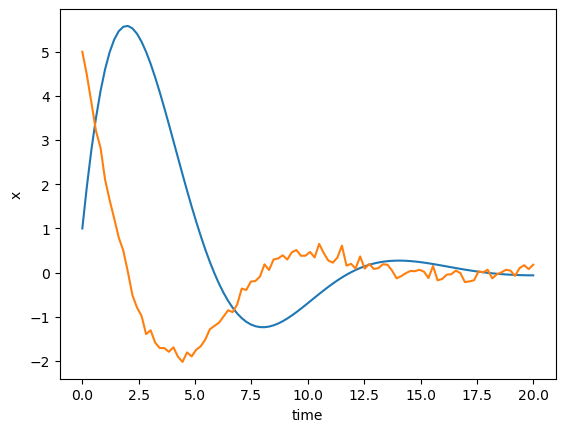

In [56]:
# plot results
plt.plot(t,solu2)
plt.xlabel('time')
plt.ylabel('x')
plt.show()

In [43]:
df = pd.DataFrame(solu2, columns= ['v', 'x'])
df.to_csv("grace_noisy_try1")

In [57]:
def diffyqs(X, t, m, b, k): # fn to pass to solver (essentially identical to the Julia solver but indexed different)
    x, vx = X[0], X[1]
    dx = vx
    dv = (1/ m) * (-k * x - b * vx)
    return [dx, dv]

## The problem

We have some (noisy) data that obeys the following nonlinear ODE:

$$ m \ddot{x} + b \dot{x} + k x = 0 $$

where $m, k > 0$ and $b \geq 0 $

We'd like to be able to determine the values of $\beta$ and $\epsilon$ from this trajectory data using PyVBMC. Since we generated the data, we know that $\beta = \epsilon = 1.5$ (a very nonlinear oscillator!), but let's pretend like we don't know that.


To get started let's read in the data and plot it with `matplotlib`:

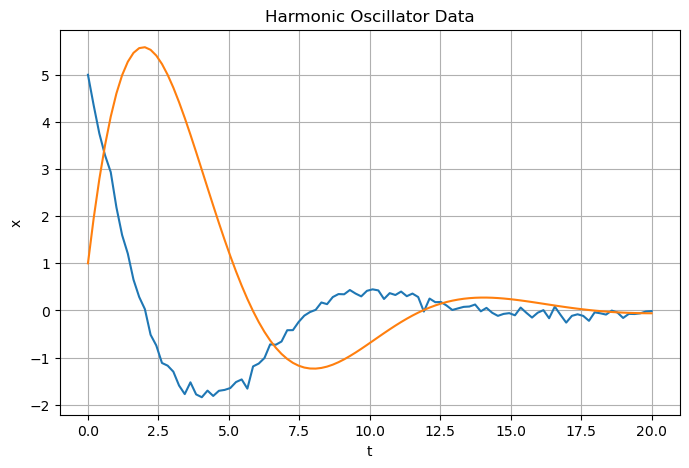

In [58]:
data = pd.read_csv("/Users/gracerojo/Downloads/DiffEqThings/grace_noisy_try1")

velo = data["v"]
x_true = data["x"]


plt.figure(figsize=(8,5))
plt.plot(t,x_true)
plt.plot(t,velo)
plt.title('Harmonic Oscillator Data')
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
plt.show()

To get our log likelihood, we need a way to generate trajectories of the duffing equation. For this we will use Scipy's `odeint` we'll treat this as a black-box ODE solver for now (I have absolutley no clue how the lsoda algorithm works). Anywho, we need a differential equation function for this just like when we solved ODE's with Julia:

In [59]:
def diffyqs(X, t, m, b, k): # fn to pass to solver (essentially identical to the Julia solver but indexed different)
    x, vx = X[0], X[1]
    dx = vx
    dv = (1/ m) * (-k * x - b * vx)
    return [dx, dv]

In [14]:
def diffyqs2(X, t, beta):
    x, vx = X[0], X[1]
    dx = vx
    dv = -beta*x
    return [dx, dv]

We'll also need an initial condition. This will remain the same for the rest of this problem since we're always looking at the same trajectory from the data.

In [60]:
# initial conditions (known from generation of data, or could get from data itself)
initial_condition = [1.0, 5.0]

To see odeint in action, let's generate the noise-free version of this data (since we know the true parameter values we can cheat).

In [51]:
# epsilon = 1.5
# beta = epsilon

# sol = odeint(diffyqs, initial_condition, t, args=(epsilon,beta)) # pass odeint the differential equation, initial condition, time array, and parameters

# # plot plot plot
# plt.figure(figsize=(8,5))
# plt.plot(t,x_true, label = 'true data')
# plt.plot(t,sol.T[1], label = 'odeint trajectory') # to get the right part of the solution you have to do this weird transpose index thing
# plt.title('Simulated and Real Data')
# plt.xlabel('t')
# plt.ylabel('x')
# plt.legend()
# plt.grid()x
# plt.show()

Now let's get ready to use PyVBMC. First we'll define a `log_likelihood` function that returns the log of the probability density of a given choice of parameters. Here we assume a normal distribution.

In [65]:
def log_likelihood(theta):
    m, b, k = theta # unpack parameters from theta

    
    sigma = 0.1 # we just know this from when I added gaussian noise to the data, not sure how you would get this in practice (error bars??)

    sol = odeint(diffyqs, initial_condition, t, args=(m, b, k)) # get solution of ODE with current choice of params
    
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5)) - (0.5/sigma**2) * (sol.T[1] - x_true)**2) # normal distribution

Next, we need to define strict and plausible upper and lower bounds for our problem. Admittedley some of these are just picked for convienience. 

In [66]:
D = 3  # 2-D since there are 2 params we're estimating

prior_mu =  np.full((1,D), 5.0) # Mean of the prior (in theory, I think rn this is just being used to get PLB, PUB)  #np.zeros((1, D))
prior_std = 3 * np.ones((1, D)) # std of the prior

LB = np.full((1, D), 0.0)  # Lower bounds (we know from the model that they have to be positive, negative values would break odeint)
# LB[0][1] = -4.0
UB = np.full((1, D), 20.0)  # Upper bounds (picked to be reasonable)
# UB[0][1] = 4.0

PLB =  prior_mu - prior_std  # Plausible lower bounds     # PLB = scs.norm.ppf(0.1587, prior_mu, prior_std)
PUB =  prior_mu + prior_std  # Plausible upper bounds     # PUB = scs.norm.ppf(0.8413, prior_mu, prior_std)
# PLB[0][1] = -2.0
# PUB[0][1] = 2.0


x0 = np.copy(prior_mu) # starting point for inference   # 1.5 * np.ones((1, D))
# x0[0][1] = 0.2

We'll first use VBMC with a uniform box prior:

In [67]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = UniformBox(LB, UB)) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10         317.91       528.77 515652823976771.62        2        inf     start warm-up
     1         15         200.47       208.70       985.53        2        inf     
     2         20          90.80         2.14        45.76        2   1.25e+03     
     3         25          88.13         0.05         1.36        2       35.3     
     4         30          88.41         0.05         2.26        2       44.6     
     5         35          88.33         0.00         0.42        2       8.42     
     6         40          88.37         0.00         0.03        2      0.799     
     7         45          88.40         0.00         0.23        2       4.59     end warm-up
     8         50          88.43         0.00         0.10        2       2.06     
     9         55          88.47         0.

We can see convergence here:

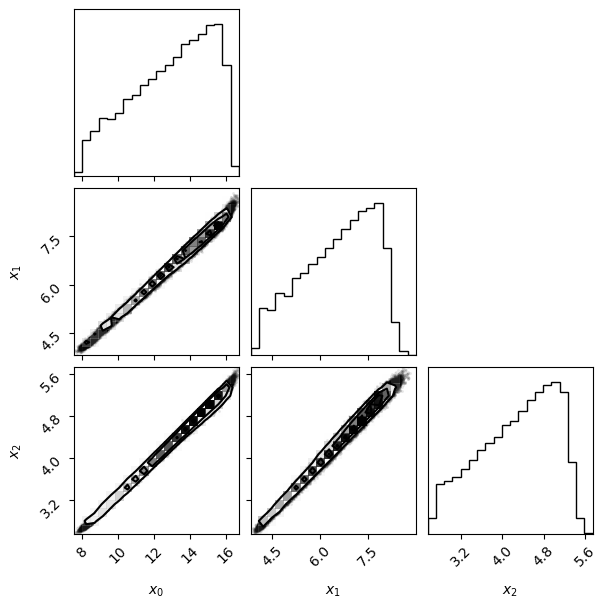

In [68]:
vp.plot();

Sampling the posterior lets us find values of interest like the mean values of posterior:

In [19]:
# First, generate a large number of samples from the variational posterior:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

# Easily compute statistics such as moments, credible intervals, etc.
post_mean = np.mean(Xs, axis=0)  # Posterior mean
post_cov = np.cov(Xs.T)  # Posterior covariance matrix
print("The approximate posterior mean is:", post_mean)
#print("The approximate posterior covariance matrix is:\n", post_cov)

The approximate posterior mean is: [ 5.17571937 -0.12363685]


We can use these mean values with odeint to produce a new trajcetory and see how good PyVBMC did:

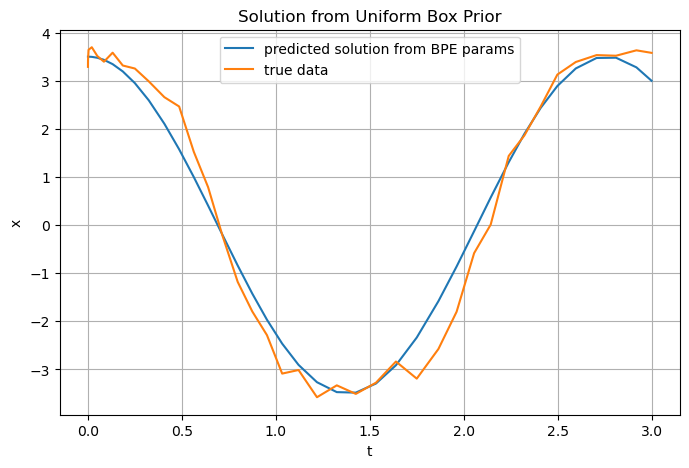

In [22]:
beta =  post_mean[0]
# beta = post_mean[1]

sol = odeint(diffyqs2, initial_condition, t, args=(beta,))

plt.figure(figsize=(8,5))
plt.title("Solution from Uniform Box Prior")
plt.plot(t,sol.T[1], label = "predicted solution from BPE params")
plt.plot(t,x_true, label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

Now, lets repeat the process of running PyVBMC but with normal distributions for the prior:

In [23]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = [scs.norm(loc = 5), scs.norm(loc=.3)]) # loc is location (mu), could also specify scale for standard deviation (sigma). List twice because 2d problem

vp, results = vbmc.optimize()

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10         -40.64        11.22 174078855316053.62        2        inf     start warm-up
     1         15         -44.80         0.18        24.07        2        inf     
     2         20         -44.85         0.00         0.00        2      0.253     
     3         25         -44.83         0.00         0.01        2      0.248     
     4         30         -44.84         0.00         0.01        2      0.174     
     5         35         -44.87         0.00         0.00        2      0.185     
     6         40         -44.85         0.00         0.01        2      0.178     
     7         45         -44.84         0.00         0.01        2      0.217     end warm-up
     8         50         -44.82         0.00         0.00        2      0.141     
     9         55         -44.83         0.

The approximate posterior mean is: [ 5.1715332  -0.12133321]


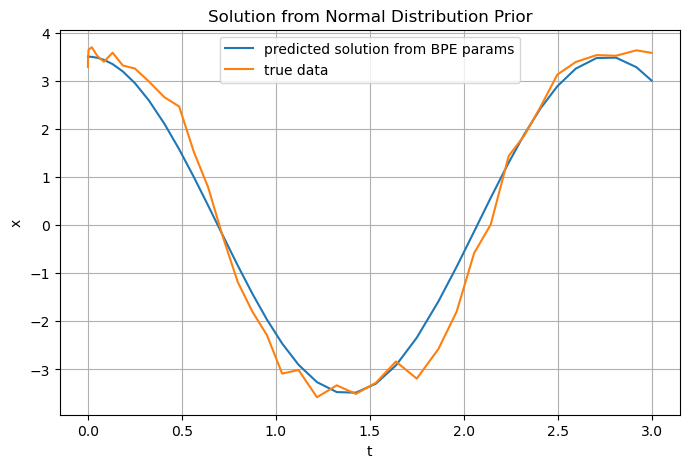

In [27]:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

post_mean = np.mean(Xs, axis=0)  # Posterior mean
print("The approximate posterior mean is:", post_mean)


# epsilon =  post_mean[0]
beta = post_mean[0]

sol = odeint(diffyqs2, initial_condition, t, args=(beta,))

plt.figure(figsize=(8,5))
plt.title("Solution from Normal Distribution Prior")
plt.plot(t,sol.T[1], label = "predicted solution from BPE params")
plt.plot(t,x_true, label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

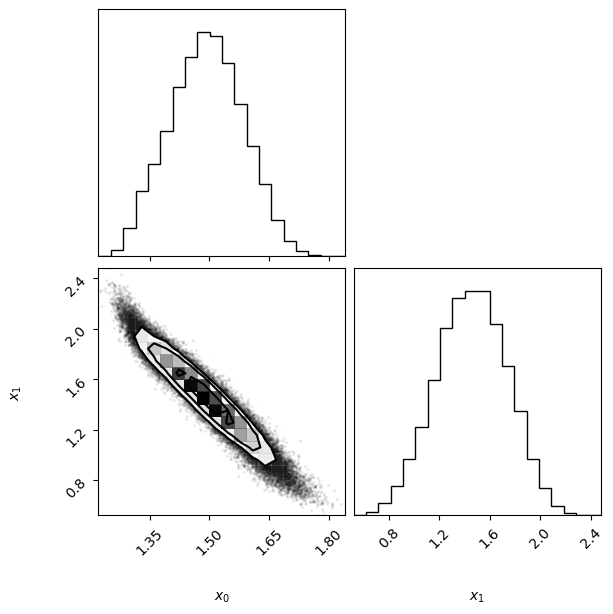

In [13]:
vp.plot();